In [2]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from river.decomposition import OnlineDMD
from river.preprocessing import Hankelizer
from river.utils import Rolling

Rolling.learn_one = Rolling.update  # type: ignore
sys.path.append("../")

from functions.chdsubid import SubIDChangeDetector  # noqa: E402
from functions.datasets import load_skab  # noqa: E402
from functions.metrics import chp_score  # noqa: E402

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Read data
dfs = load_skab("data/skab")
dfs_free = [
    df
    for key, df_group in dfs.items()
    for df in df_group
    if key == "anomaly-free"
]
dfs_: list[pd.DataFrame] = [
    pd.DataFrame(df)
    for key, df_group in dfs.items()
    for df in df_group
    if key != "anomaly-free"
]
for df in dfs_:
    df.index = pd.to_datetime(df.index)

In [25]:
# Prepare arrays for storing results
scores_datasets = []
predicted_outlier, predicted_cp = [], []

# Iterate datasets
for i, df in enumerate(dfs_):
    print(f"Processing dataset {i+1}/{len(dfs_)}", end="\r")
    # Initialize Hankelizer
    hn = 30
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    r = 2
    init_size = 400
    odmd = Rolling(
        OnlineDMD(
            r=r,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )

    # Initialize Change-Point Detector
    ref_size = 300
    test_size = 30
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + test_size + 1,
        threshold=df.std().mean() / 100,
        learn_after_grace=False,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    X = df.drop(["anomaly", "changepoint"], axis=1)

    scores_dmd = []
    predictions = []
    # Run pipeline
    for j, x in enumerate(X.to_dict(orient="records")):
        if (j + 1) % 1000 == 0:
            print(f"\rProcessed {j + 1}/{len(X)} {' ':<80}", end="\r")
        pipeline_dmd.learn_one(x)

        if j >= init_size + test_size:
            scores_dmd.append(subid_dmd.score)
            predictions.append(subid_dmd._drift_detected)

    prediction = (
        pd.Series(predictions, index=X.index[init_size + test_size :])
        .astype(int)
        .rolling(30)
        .max()
        .fillna(0)
    )

    scores_datasets.append(
        pd.Series(scores_dmd, index=X.index[init_size + test_size :])
    )
    predicted_outlier.append(prediction)
    prediction_cp = prediction.diff().abs()
    prediction_cp.iloc[0] = prediction.iloc[0]
    predicted_cp.append(prediction_cp)

Processed 1000/112934/34rocessing dataset 2/34Processing dataset 3/34Processing dataset 4/34Processing dataset 5/34Processing dataset 6/34Processing dataset 7/34Processing dataset 8/34Processing dataset 9/34Processing dataset 10/34Processing dataset 11/34Processing dataset 12/34Processing dataset 13/34Processing dataset 14/34Processing dataset 15/34Processing dataset 16/34Processing dataset 17/34Processing dataset 18/34Processing dataset 19/34Processing dataset 20/34Processing dataset 21/34Processing dataset 23/34Processing dataset 26/34Processing dataset 27/34Processing dataset 29/34Processing dataset 30/34Processing dataset 31/34Processing dataset 32/34Processing dataset 33/34

In [26]:
true_outlier = [df["anomaly"] for df in dfs_]
true_cp = [df["changepoint"] for df in dfs_]

In [27]:
pos = []
for sd in scores_datasets:
    pos.append((sd > 0.001).astype(int))

In [28]:
pcs = []
for prediction in pos:
    pc = prediction.diff().abs()
    pc.iloc[0] = prediction.iloc[0]
    pcs.append(pc)

In [29]:
binary = chp_score(true_outlier, pos, metric="binary")

False Alarm Rate 45.23 %
Missing Alarm Rate 47.19 %
F1 metric 0.56


In [30]:
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="lefter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 44
A number of FPs = 127
Average time 0 days 00:01:25.200000


In [32]:
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30s",
    anomaly_window_destination="center",
)

Standard  -  8.98
LowFP  -  -2.65
LowFN  -  15.29


# Visualize results

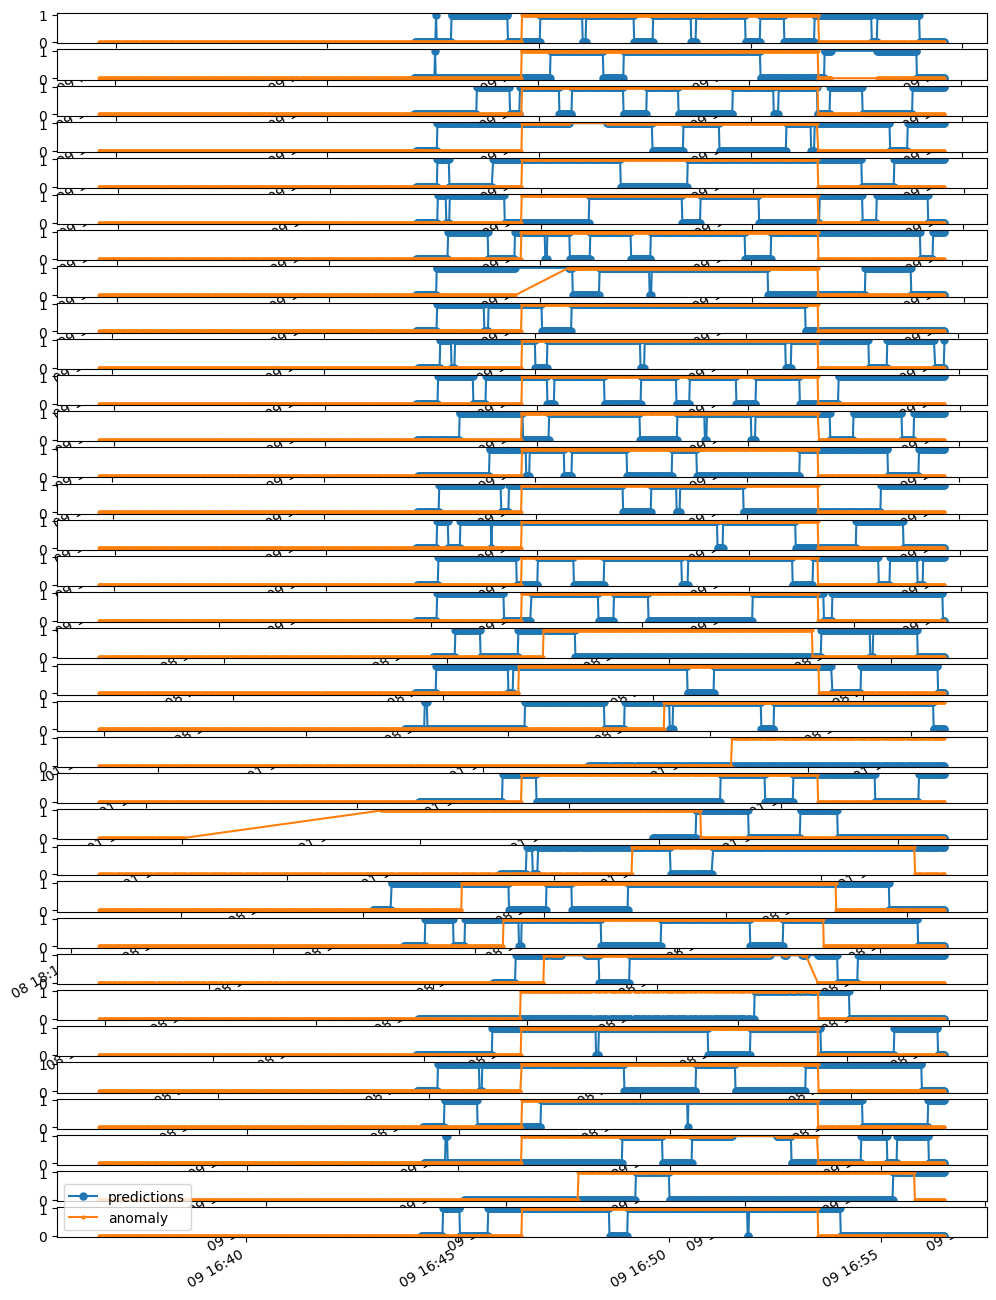

In [33]:
# true outlier indices selection
true_outlier = [df.anomaly for df in dfs_]

fig, axs = plt.subplots(len(dfs_), 1, figsize=(12, 18))
for ax, to, po in zip(axs, true_outlier, predicted_outlier):
    po.astype(int).plot(label="predictions", marker="o", markersize=5, ax=ax)
    to.plot(marker="o", markersize=2, ax=ax)
    ax.set_xlabel("")
ax.legend()

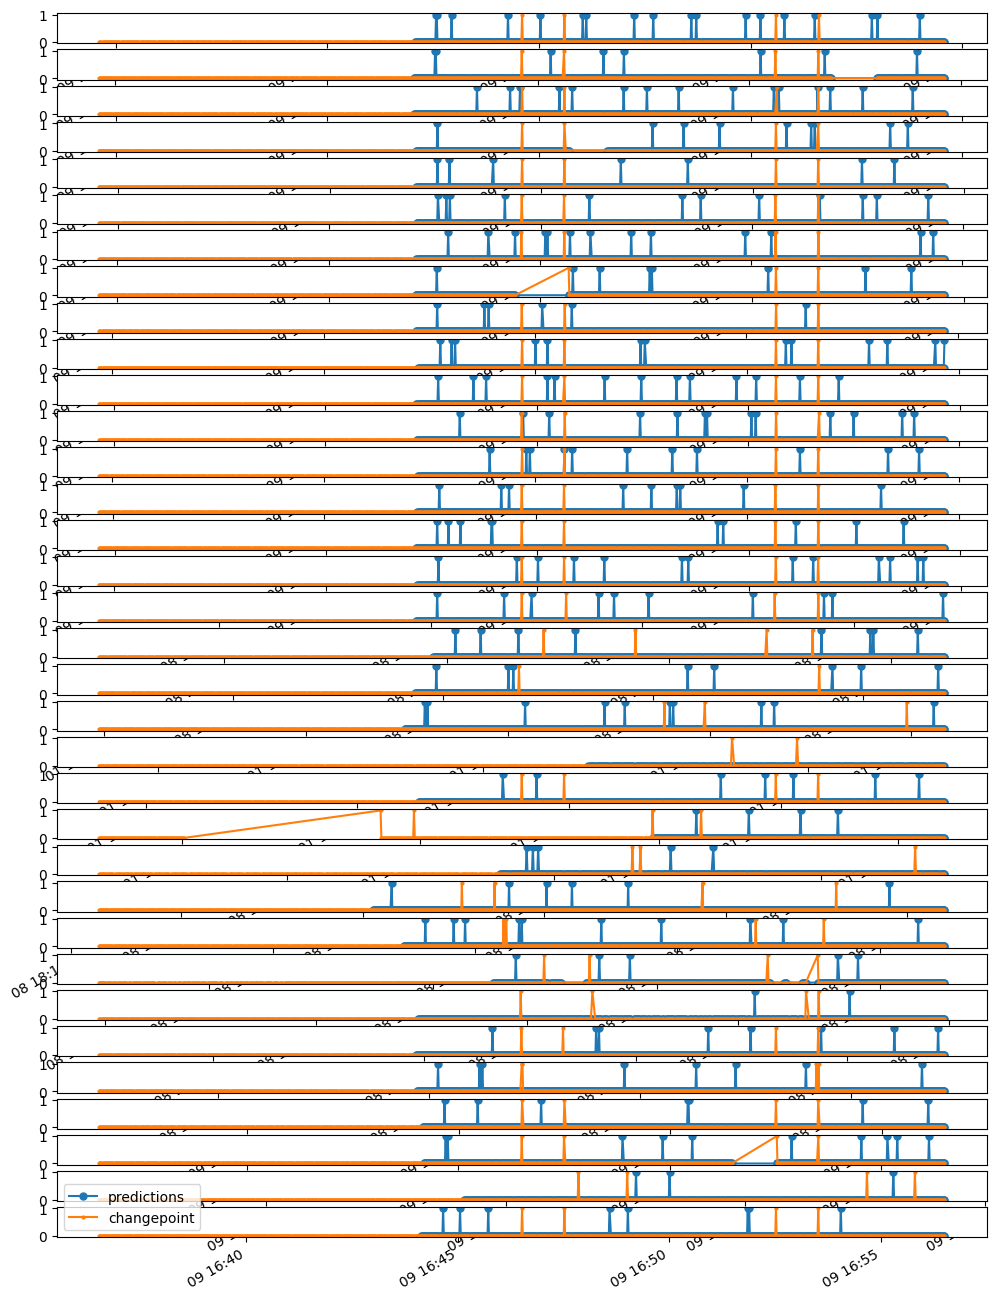

In [34]:
# true changepoint indices selection
true_cp = [df.changepoint for df in dfs_]

fig, axs = plt.subplots(len(dfs_), 1, figsize=(12, 18))
for ax, tc, pc in zip(axs, true_cp, predicted_cp):
    pc.plot(label="predictions", marker="o", markersize=5, ax=ax)
    tc.plot(marker="o", markersize=2, ax=ax)
    ax.set_xlabel("")
ax.legend()